In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from pyproj import CRS
from pyproj import Transformer
#from converter import wgs84_to_gcj02    #参见注意事项

### 6. Draw AQI (PM2.5) Image with Countour

### 6.1 Prepare x,y,z Data 

In [4]:
df_all = pd.read_csv(r'D:\Tommy\+WeatherData\china_aqi_map\aqi_all.csv')
print(df_all)

       s_id loc_name  city       lon       lat  value
0     1001A     万寿西宫    北京  116.3621  39.87840   47.0
1     1002A  定陵(对照点)    北京  116.2202  40.29150   12.0
2     1003A       东四    北京  116.4174  39.92890   65.0
3     1004A       天坛    北京  116.4072  39.88630   45.0
4     1005A      农展馆    北京  116.4620  39.93650   44.0
...     ...      ...   ...       ...       ...    ...
1697  3734A     理想之城    东营  118.3500  37.26000   51.0
1698  3860A   皇山花园小区    临沂  118.3920  35.03000   32.0
1699  3861A  寒亭区实验一小    潍坊  119.2041  36.76990   39.0
1700  3866A      三高中    营口  122.2469  40.66302   22.0
1701  3867A  平安区公安北苑  海东地区  102.0738  36.50560   39.0

[1702 rows x 6 columns]


### 6.2 Convert lat,lon to x,y(Mercator)

In [5]:
#WGS84 convert to web Mercator
from_crs_2 = CRS.from_epsg(4326)
to_crs_2 = CRS.from_epsg(3857)
transformer_2 = Transformer.from_crs(from_crs_2, to_crs_2, always_xy=True)

In [6]:
def get_x(r):
    x3,y3 = transformer_2.transform(r['lon'], r['lat'])
    return x3
def get_y(r):
    x3,y3 = transformer_2.transform(r['lon'], r['lat'])
    return y3
df_all['xx'] = df_all.apply(get_x, axis=1)
df_all['yy'] = df_all.apply(get_y, axis=1)

In [7]:
print(df_all)

       s_id loc_name  city       lon       lat  value            xx  \
0     1001A     万寿西宫    北京  116.3621  39.87840   47.0  1.295337e+07   
1     1002A  定陵(对照点)    北京  116.2202  40.29150   12.0  1.293757e+07   
2     1003A       东四    北京  116.4174  39.92890   65.0  1.295953e+07   
3     1004A       天坛    北京  116.4072  39.88630   45.0  1.295839e+07   
4     1005A      农展馆    北京  116.4620  39.93650   44.0  1.296449e+07   
...     ...      ...   ...       ...       ...    ...           ...   
1697  3734A     理想之城    东营  118.3500  37.26000   51.0  1.317466e+07   
1698  3860A   皇山花园小区    临沂  118.3920  35.03000   32.0  1.317934e+07   
1699  3861A  寒亭区实验一小    潍坊  119.2041  36.76990   39.0  1.326974e+07   
1700  3866A      三高中    营口  122.2469  40.66302   22.0  1.360846e+07   
1701  3867A  平安区公安北苑  海东地区  102.0738  36.50560   39.0  1.136280e+07   

                yy  
0     4.848287e+06  
1     4.908393e+06  
2     4.855616e+06  
3     4.849433e+06  
4     4.856719e+06  
...            ...  


In [8]:
print(df_all)

       s_id loc_name  city       lon       lat  value            xx  \
0     1001A     万寿西宫    北京  116.3621  39.87840   47.0  1.295337e+07   
1     1002A  定陵(对照点)    北京  116.2202  40.29150   12.0  1.293757e+07   
2     1003A       东四    北京  116.4174  39.92890   65.0  1.295953e+07   
3     1004A       天坛    北京  116.4072  39.88630   45.0  1.295839e+07   
4     1005A      农展馆    北京  116.4620  39.93650   44.0  1.296449e+07   
...     ...      ...   ...       ...       ...    ...           ...   
1697  3734A     理想之城    东营  118.3500  37.26000   51.0  1.317466e+07   
1698  3860A   皇山花园小区    临沂  118.3920  35.03000   32.0  1.317934e+07   
1699  3861A  寒亭区实验一小    潍坊  119.2041  36.76990   39.0  1.326974e+07   
1700  3866A      三高中    营口  122.2469  40.66302   22.0  1.360846e+07   
1701  3867A  平安区公安北苑  海东地区  102.0738  36.50560   39.0  1.136280e+07   

                yy  
0     4.848287e+06  
1     4.908393e+06  
2     4.855616e+06  
3     4.849433e+06  
4     4.856719e+06  
...            ...  


In [9]:
x = df_all['xx'].values
y = df_all['yy'].values
z = df_all['value'].values

In [10]:
print(x)
print(y)
print(z)

[12953369.71963598 12937573.48389241 12959525.68747685 ...
 13269739.71247046 13608462.65905624 11362803.43933445]
[4848287.40122816 4908393.12504335 4855615.5940864  ... 4407082.16188918
 4962763.53496164 4370416.03639781]
[47. 12. 65. ... 39. 22. 39.]


### 6.3 PPrepare the grid 

In [11]:
# size of the grid to interpolate
nx, ny = 650, 400 
lonmin = 71
lonmax = 136
latmin = 15
latmax = 55

#top left
x1,y1 = transformer_2.transform(lonmin, latmax)
#bottom right
x2,y2 = transformer_2.transform(lonmax, latmin)

xmin = x1
xmax = x2
ymin = y2
ymax = y1

print(xmin,xmax,ymin,ymax)
# generate two arrays of evenly space data between ends of previous arrays
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymin, ymax, ny)
print(xi)
print(yi)

7903683.846322423 15139450.747885207 1689200.1396078924 7361866.113051185
[ 7903683.84632242  7914832.94786566  7925982.0494089   7937131.15095214
  7948280.25249538  7959429.35403862  7970578.45558186  7981727.5571251
  7992876.65866834  8004025.76021158  8015174.86175482  8026323.96329806
  8037473.0648413   8048622.16638454  8059771.26792778  8070920.36947102
  8082069.47101426  8093218.5725575   8104367.67410074  8115516.77564398
  8126665.87718722  8137814.97873046  8148964.0802737   8160113.18181694
  8171262.28336018  8182411.38490342  8193560.48644666  8204709.5879899
  8215858.68953314  8227007.79107638  8238156.89261962  8249305.99416286
  8260455.0957061   8271604.19724934  8282753.29879258  8293902.40033582
  8305051.50187906  8316200.6034223   8327349.70496554  8338498.80650878
  8349647.90805202  8360797.00959526  8371946.1111385   8383095.21268174
  8394244.31422498  8405393.41576822  8416542.51731146  8427691.61885471
  8438840.72039795  8449989.82194118  8461138.923484

### 6.4 plot heatmap with countour

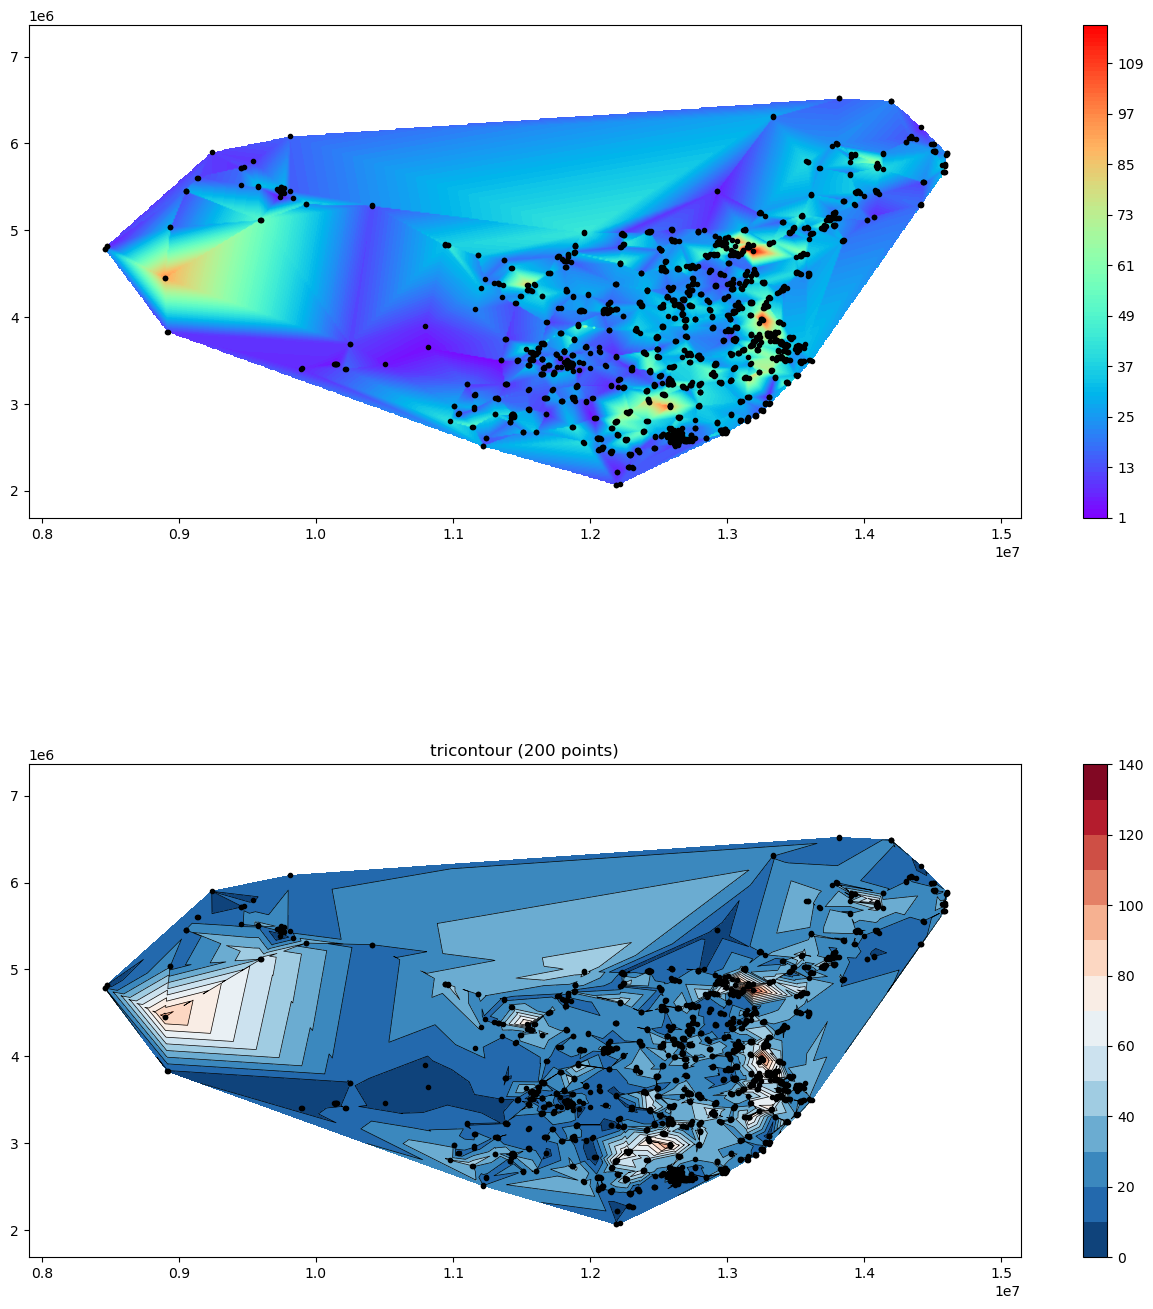

In [21]:
import matplotlib.tri as tri

fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(16,16))
npts = 200

# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

#ax1.contour(xi, yi, zi, levels=140, linewidths=0.5, colors='k')
cntr1 = ax1.contourf(xi, yi, zi, levels=140, cmap="rainbow")

fig.colorbar(cntr1, ax=ax1)
ax1.plot(x, y, 'ko', ms=3)
ax1.set(xlim=(xmin, xmax), ylim=(ymin,ymax))
#ax1.set_title('grid and contour (%d points, %d grid points)' %
#              (npts, ngridx * ngridy))

# ----------
# Tricontour
# ----------
# Directly supply the unordered, irregularly spaced coordinates
# to tricontour.

ax2.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(x, y, 'ko', ms=3)
ax2.set(xlim=(xmin, xmax), ylim=(ymin,ymax))
ax2.set_title('tricontour (%d points)' % npts)

plt.subplots_adjust(hspace=0.5)
plt.show()